In [1]:
%load_ext autoreload
%autoreload 2

import cv2
import matplotlib.pyplot as plt
import numpy as np
import open3d as o3d

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


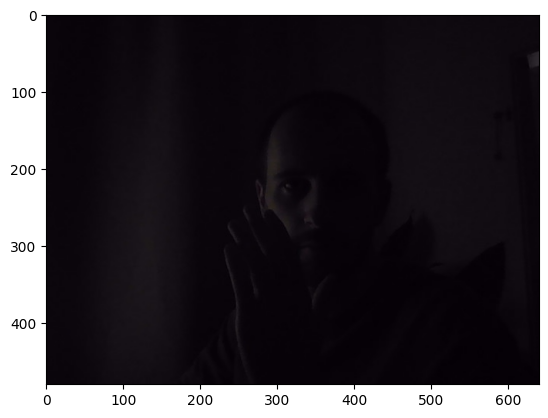

In [2]:
# Capture Frame
cap = cv2.VideoCapture(0)
ret, frame = cap.read()
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
cap.release()

plt.imshow(frame)
plt.show()

In [171]:
frame2 = cv2.imread('../assets/alex_test.jpg')

In [138]:
def apply_erosion_filter(point_cloud, radius=10, min_neighbors=10):
    # Compute the neighborhood for each point
    kdtree = o3d.geometry.KDTreeFlann(point_cloud)
    points_to_keep = []

    for i in range(len(point_cloud.points)):
        # Find neighbors within the given radius
        [_, idx, _] = kdtree.search_radius_vector_3d(point_cloud.points[i], radius)
        
        # Keep the point if the number of neighbors is above the threshold
        if len(idx) > min_neighbors:
            points_to_keep.append(i)
    
    # Filter the point cloud
    filtered_points = np.asarray(point_cloud.points)[points_to_keep]

    # Create a new point cloud with the filtered points
    filtered_point_cloud = o3d.geometry.PointCloud()
    filtered_point_cloud.points = o3d.utility.Vector3dVector(filtered_points)

    return filtered_point_cloud

In [159]:
import sys
sys.path.append('../pipeline')

from pipeline.components.pc_generator.DepthEstimator import DepthEstimator
from pipeline.components.pc_generator.PointCloudGenerator import PointCloudGenerator
from pipeline.components.pc_generator.DepthThresholder import DepthThresholder

# Pipeline Starter
depth_estimator = DepthEstimator(visualize=False)
#pointcloud_generator = PointCloudGenerator(visualize=False)
dept_thresh = DepthThresholder(visualize=False)

"""
depth_image = depth_estimator.run_step(frame)
plt.imshow(depth_image)
plt.show()

pcd = pointcloud_generator.run_step(frame, depth_image)

o3d.visualization.draw_geometries([pcd], width=800, height=600)

pcd_filtered = apply_erosion_filter(pcd)
o3d.visualization.draw_geometries([pcd_filtered], width=800, height=600)
"""

'\ndepth_image = depth_estimator.run_step(frame)\nplt.imshow(depth_image)\nplt.show()\n\npcd = pointcloud_generator.run_step(frame, depth_image)\n\no3d.visualization.draw_geometries([pcd], width=800, height=600)\n\npcd_filtered = apply_erosion_filter(pcd)\no3d.visualization.draw_geometries([pcd_filtered], width=800, height=600)\n'

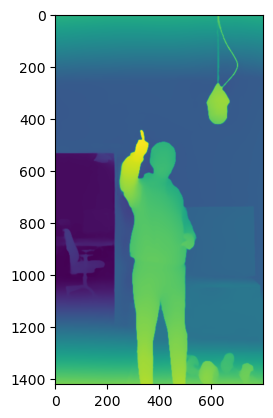

In [172]:
depth_image = depth_estimator.run_step(frame2)
plt.imshow(depth_image)
plt.show()

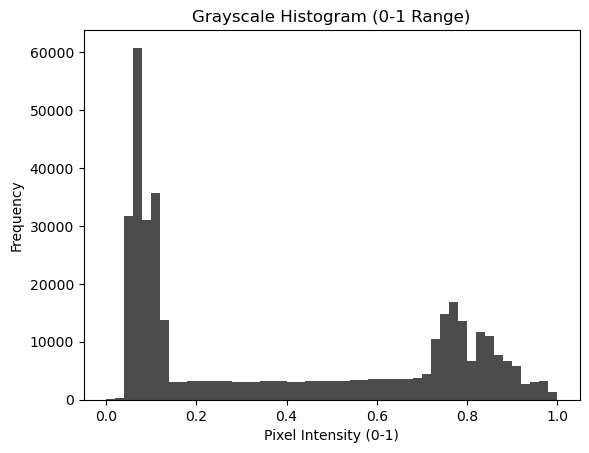

mean: 0.3931557834148407


In [168]:
pixel_array = depth_image.ravel()

# Plot histogram using Matplotlib
plt.figure()
plt.title("Grayscale Histogram (0-1 Range)")
plt.xlabel("Pixel Intensity (0-1)")
plt.ylabel("Frequency")
plt.hist(pixel_array, bins=50, range=[0, 1], color='black', alpha=0.7)  # Use 50 bins for better visibility
plt.show()

print(f"mean: {pixel_array.mean()}")

In [242]:
def get_mask(depth_image):
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(16, 6))
    
    image255 = (depth_image * 255).astype(np.uint8)
    depth_map_n = cv2.normalize(image255, None, 0, 255, cv2.NORM_MINMAX)
    
    axes[0, 0].set_title("depth map")
    axes[0, 0].imshow(depth_map_n)
        
    gradient = cv2.morphologyEx(depth_map_n, cv2.MORPH_GRADIENT, np.ones((3,3), np.uint8))
    
    axes[0, 1].set_title("gradient")
    axes[0, 1].imshow(gradient)
    
    _, edges = cv2.threshold(gradient, 10, 255, cv2.THRESH_BINARY)
    
    axes[0, 2].set_title("edges")
    axes[0, 2].imshow(edges)
    
    # Threshold to create an initial binary mask
    _, sure_fg = cv2.threshold(depth_map_n, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    axes[0, 3].set_title("sure_fg")
    axes[0, 3].imshow(sure_fg)
    
    
    # Garadient Thresholding
    gradient_y = cv2.Sobel(depth_map_n, cv2.CV_64F, 0, 1, ksize=5)
    gradient_y_abs = cv2.convertScaleAbs(gradient_y)
    floor_and_ceiling = cv2.inRange(gradient_y_abs, 35, 100)
    # opening to remove edges
    kernel = np.ones((15, 15), np.uint8)
    floor_and_ceiling = cv2.morphologyEx(floor_and_ceiling, cv2.MORPH_OPEN, kernel)
    
    axes[0, 4].set_title("floor_and_ceiling")
    axes[0, 4].imshow(floor_and_ceiling)
    
    # Remove Edges that are in the bg for sure
    edges = cv2.bitwise_and(edges, edges, mask=sure_fg)
    kernel = np.ones((3, 3), np.uint8)
    edges = cv2.dilate(edges, kernel, iterations=1)
    
    # add border to the image because feet are often missing
    border_height = 1
    edges = cv2.copyMakeBorder(edges, 0, border_height, 0, 0, cv2.BORDER_CONSTANT, value=[255, 255, 255])
    
    kernel = np.ones((15, 15), np.uint8)
    edges = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)
    edges = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)
    
    edges = cv2.ximgproc.thinning(edges)
    
    
    axes[1, 0].set_title("edges filtered")
    axes[1, 0].imshow(edges)
    
    # Fill biggest contours
    """
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    filled_image = np.zeros_like(edges)
    biggest_contour_idx = np.argmax([cv2.contourArea(c) for c in contours])
    cv2.drawContours(filled_image, contours, biggest_contour_idx, (255), thickness=cv2.FILLED)
    
    # remove border
    filled_image = filled_image[:filled_image.shape[0] - border_height, :]

    
    """
    # Create an empty output image
    filled_image = np.zeros_like(edges)
    # Scan each row for edge boundaries and fill gaps
    for row in range(edges.shape[0]):
        edge_pixels = np.where(edges[row] == 255)[0]  # Find the columns where edges exist
        if len(edge_pixels) > 0:
            start, end = edge_pixels[0], edge_pixels[-1]  # Get the first and last edge pixel in the row
            filled_image[row, start:end+1] = 255  # Fill the gap with white (255) between edges
    filled_image = filled_image[:filled_image.shape[0] - border_height, :]
    
    """
    height, width = edges.shape
    filled_image = np.zeros_like(edges)
    for row in range(height):
        is_filling = False  # Track filling state
        for col in range(width):
            pixel = edges[row, col]
            
            if pixel > 0:  # Edge detected
                is_filling = not is_filling  # Toggle filling on/off
                
            if is_filling:  # Fill when inside an edge region
                filled_image[row, col] = 255
                
        filled_image = filled_image[:filled_image.shape[0] - border_height, :]
     """                   
    
    
    axes[1, 1].set_title("filled")
    axes[1, 1].imshow(filled_image)
    
    bg_total = cv2.bitwise_not(sure_fg)
    bg_total = cv2.bitwise_or(bg_total, floor_and_ceiling)
    #test_mask = cv2.bitwise_and()
    
    axes[1, 2].set_title("bg_total")
    axes[1, 2].imshow(bg_total)
    
    final_mask = cv2.bitwise_and(filled_image, filled_image, mask=cv2.bitwise_not(bg_total))
    kernel = np.ones((7, 7), np.uint8)
    final_mask = cv2.morphologyEx(final_mask, cv2.MORPH_OPEN, kernel)
    
    axes[1, 3].set_title("foreground mask")
    axes[1, 3].imshow(final_mask)
    
    # Finally, find the biggest shape that got filtered out
    contours, _ = cv2.findContours(final_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    biggest_shape = np.zeros_like(final_mask)
    biggest_contour_idx = np.argmax([cv2.contourArea(c) for c in contours])
    cv2.drawContours(biggest_shape, contours, biggest_contour_idx, (255), thickness=cv2.FILLED)
    
    final_shape = cv2.bitwise_and(final_mask, final_mask, mask=biggest_shape)
    
    axes[1, 4].set_title("final mask")
    axes[1, 4].imshow(final_shape)
    
    plt.tight_layout()
    plt.show()

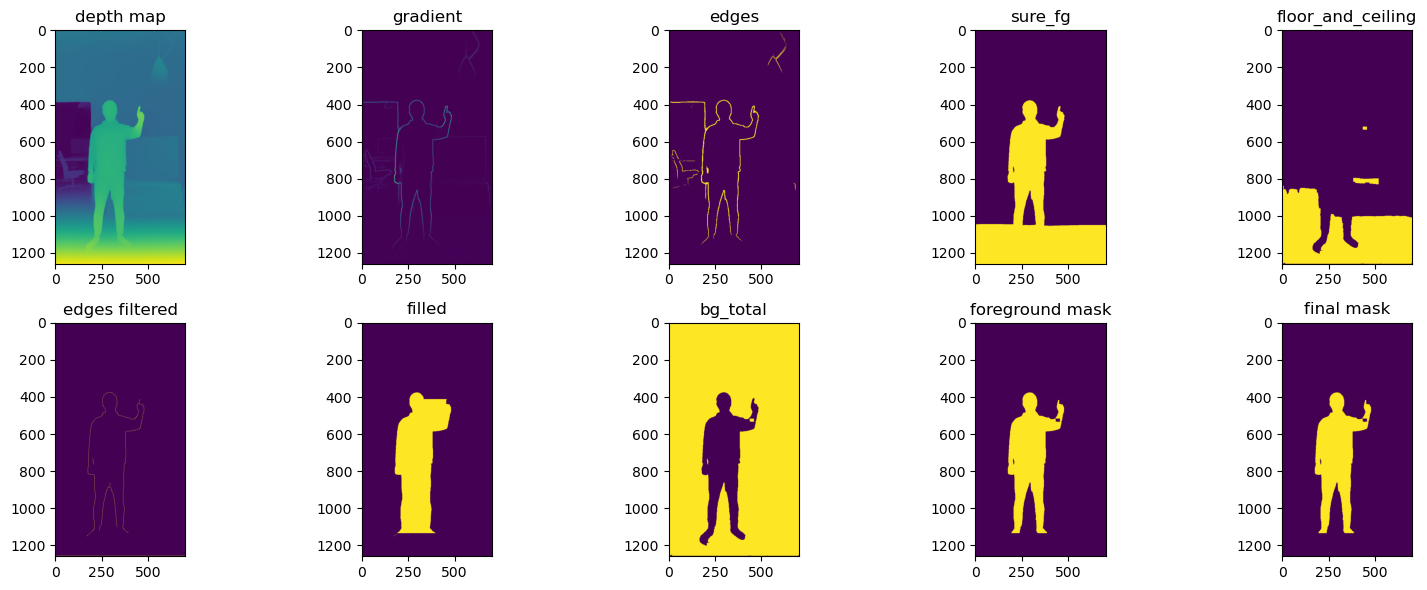

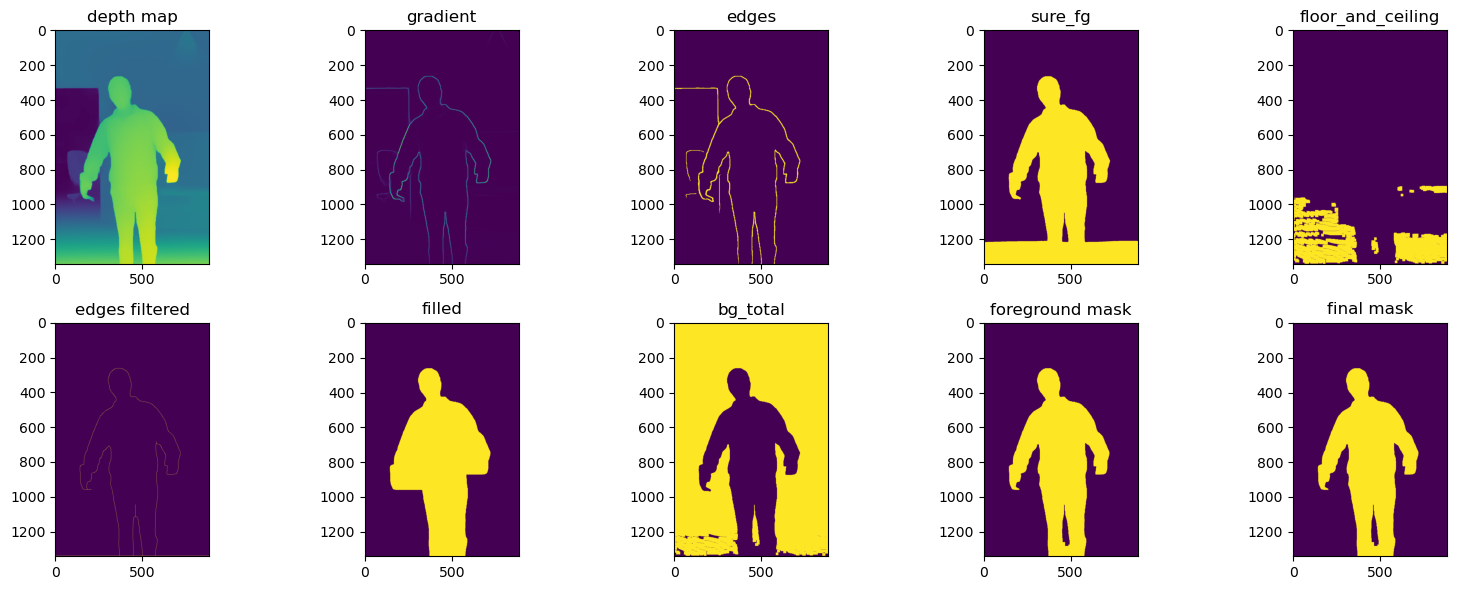

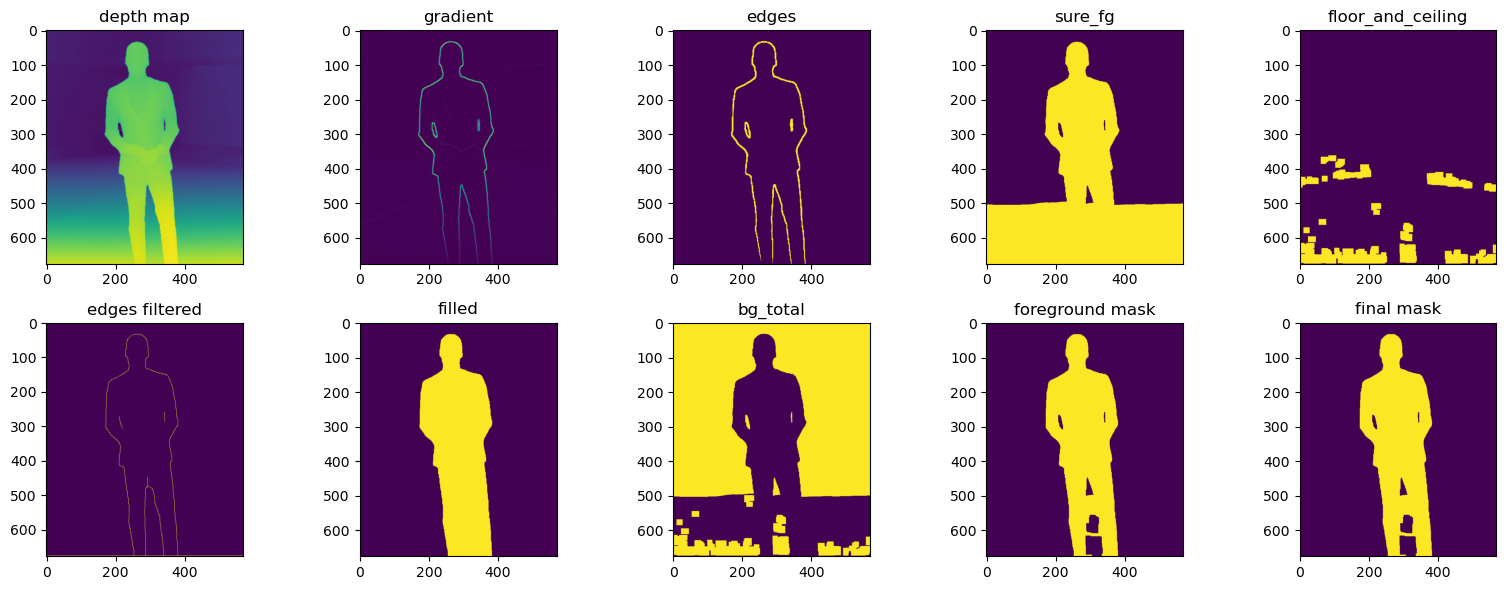

In [243]:
depth_image = depth_estimator.run_step(cv2.imread('../assets/alex_test3.jpg'))
get_mask(depth_image)

depth_image = depth_estimator.run_step(cv2.imread('../assets/alex_test2.jpg'))
get_mask(depth_image)

depth_image = depth_estimator.run_step(cv2.imread('../assets/news-anchor.jpg'))
get_mask(depth_image)

C:\dev\TU\ODS\ods-playground\vendor\Depth-Anything-V2
torch.Size([256, 256])
tensor([[9.1502e-10, 1.1910e-09, 3.3071e-09,  ..., 1.5228e-08, 4.3938e-08,
         1.6434e-07],
        [5.3893e-10, 6.6110e-10, 2.9165e-09,  ..., 2.6955e-08, 4.9634e-08,
         1.3678e-07],
        [6.2908e-10, 1.1504e-09, 7.6736e-09,  ..., 7.1110e-08, 8.1565e-08,
         1.4247e-07],
        ...,
        [9.3255e-08, 4.7128e-08, 4.5477e-08,  ..., 7.6626e-08, 2.8489e-08,
         1.6026e-08],
        [1.0198e-07, 3.8676e-08, 2.6965e-08,  ..., 5.1080e-08, 2.1139e-08,
         1.2853e-08],
        [1.6163e-07, 5.7650e-08, 3.0347e-08,  ..., 4.7387e-08, 2.1505e-08,
         1.2726e-08]])


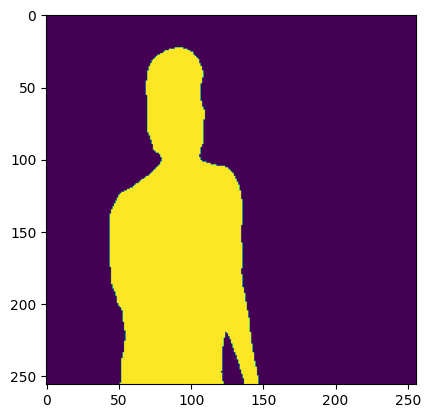

In [60]:
# TRYING WITH RMBG
import torch
from torchvision import transforms
from transformers import AutoModelForImageSegmentation
from PIL import Image

rmbg_model = AutoModelForImageSegmentation.from_pretrained('briaai/RMBG-2.0', trust_remote_code=True)
torch.set_float32_matmul_precision(['high', 'highest'][0])
rmbg_model.to('cuda')
rmbg_model.eval()

image_size = (256, 256)
transform_image = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


#depth_pillow = Image.fromarray(depth_image).convert('RGB')
input_image = Image.open('../assets/man-standing.jpg')
input_images = transform_image(input_image).unsqueeze(0).to('cuda')
with torch.no_grad():
    preds = rmbg_model(input_images)[-1].sigmoid().cpu()
pred = preds[0].squeeze()
print(pred.shape)
print(pred)

mask = pred > 0.2
plt.imshow(mask)

In [ ]:
#
# Test with SAM
#

In [ ]:
frame3 = cv2.imread('../assets/man-standing.jpg')
